## Simulating waves in the SUSTAIN tank

In this notebook we force the 1-d wave model with the mean wind data from the lab,
and compare the results with the spectrum data from the wave wire.

In [1]:
from asist.utility import power_spectrum
import matplotlib.pyplot as plt
import numpy as np
from umwm.integrate import integrate
from umwm.physics import frequency_logspace, wavenumber, phase_speed, \
                         group_speed, source_input, wind_wave_balance
import xarray as xr
from scipy.signal import detrend

import matplotlib
matplotlib.rc('font', size=16)

import warnings
warnings.filterwarnings("ignore")

## Load measurements

In [2]:
irgason = xr.open_dataset('data/irgason.nc')
wavewire = xr.open_dataset('data/wavewire.nc')

Text(0.5, 1.0, 'Along-tank velocity from IRGASON at 7-m fetch')

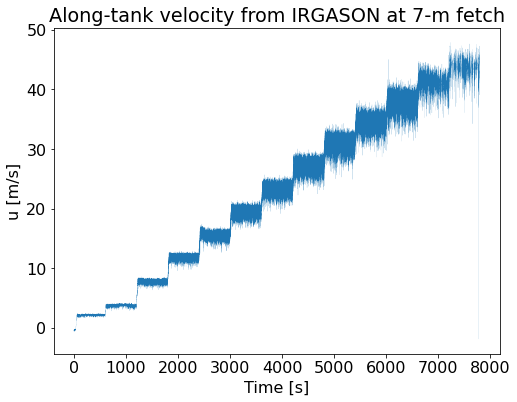

In [6]:
plt.figure(figsize=(8, 6))
plt.plot(irgason['time'], irgason['u'], lw=0.1)
plt.xlabel('Time [s]')
plt.ylabel('u [m/s]')
plt.title('Along-tank velocity from IRGASON at 7-m fetch')

Text(0.5, 1.0, 'Water elevation from wave wire at 10-m fetch')

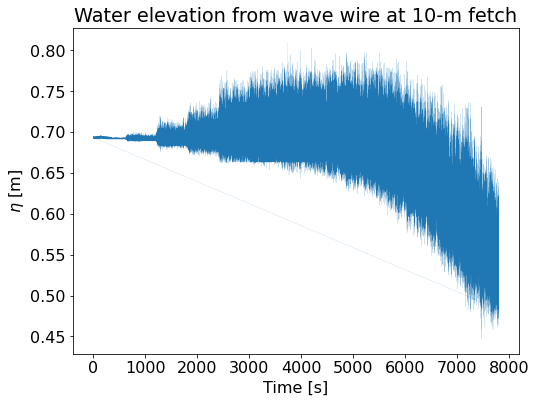

In [7]:
plt.figure(figsize=(8, 6))
plt.plot(wavewire['time'], wavewire['w1'], lw=0.1)
plt.xlabel('Time [s]')
plt.ylabel(r'$\eta$ [m]')
plt.title('Water elevation from wave wire at 10-m fetch')

In [8]:
fan = range(0, 65, 5)
run_seconds = 600
offset = 60

U = np.zeros((12))
Hs = np.zeros((12))
Tm = np.zeros((12))
Tp = np.zeros((12))
F = np.zeros((12, 5400))

for n, _ in enumerate(fan):
    if n == 0: continue
    
    t0 = n * run_seconds + offset
    t1 = (n + 1) * run_seconds
    
    mask = (irgason['time'][:] >= t0) & (irgason['time'][:] <= t1)
    U[n-1] = np.nanmean(irgason['u'][mask])
    
    mask = (wavewire['time'][:] >= t0) & (wavewire['time'][:] <= t1)
    eta = detrend(wavewire['w1'][mask])
    F[n-1,:], freq, dfreq = power_spectrum(eta, 1 / 20, binsize=1)
    fmask = (freq >= 0.5) & (freq <= 5)
    Hs[n-1] = 4 * np.sqrt(np.sum(F[n-1,fmask] * dfreq))
    Tm[n-1] = np.sum(F[n-1,fmask]) / np.sum(F[n-1,fmask] * freq[fmask])
    Tp[n-1] = np.sum(F[n-1,fmask]**4) / np.sum(F[n-1,fmask]**4 * freq[fmask])

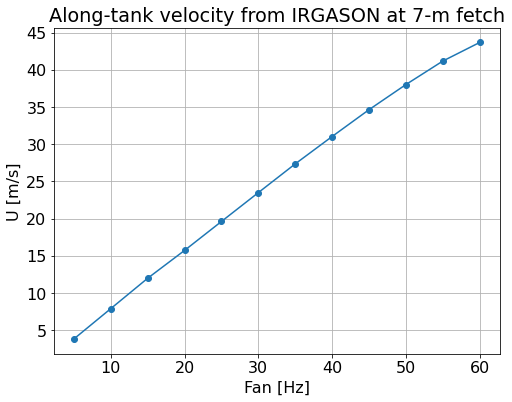

In [9]:
plt.figure(figsize=(8, 6))
plt.plot(fan[1:], U, marker='o')
plt.xlabel('Fan [Hz]')
plt.ylabel('U [m/s]')
plt.title('Along-tank velocity from IRGASON at 7-m fetch')
plt.grid()

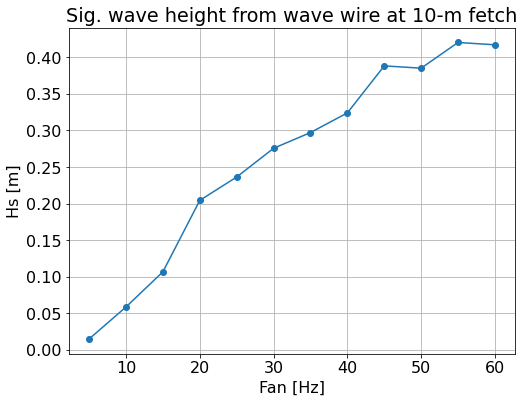

In [10]:
plt.figure(figsize=(8, 6))
plt.plot(fan[1:], Hs, marker='o')
plt.xlabel('Fan [Hz]')
plt.ylabel('Hs [m]')
plt.title('Sig. wave height from wave wire at 10-m fetch')
plt.grid()

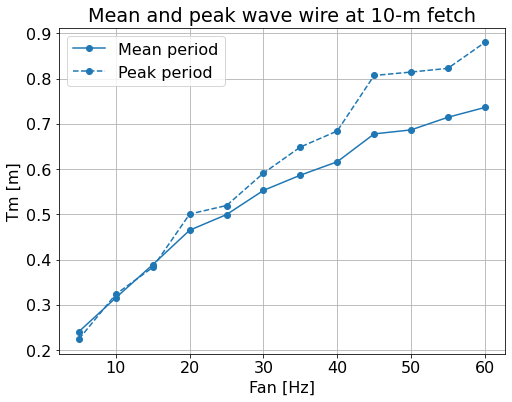

In [13]:
plt.figure(figsize=(8, 6))
plt.plot(fan[1:], Tm, color='tab:blue', marker='o', label='Mean period')
plt.plot(fan[1:], Tp, color='tab:blue', marker='o', linestyle='--', label='Peak period')
plt.legend()
plt.xlabel('Fan [Hz]')
plt.ylabel('Tm [m]')
plt.title('Mean and peak wave wire at 10-m fetch')
plt.grid()

In [14]:
def smooth(x, w):
    """A running mean smoother with a window w."""
    xx = 1 * x[:]
    for i in range(0, w // 2, 1):
        xx[i] = np.mean(x[:i+w//2])
    for i in range(w // 2, x.size - w // 2, 1):
        xx[i] = np.mean(x[i-w//2:i+w//2])
    for i in range(x.size - w // 2, x.size, 1):
        xx[i] = np.mean(x[i-w//2:])
    return xx

Text(0.5, 1.0, 'Frequency spectrum from wave wire at 10-m fetch')

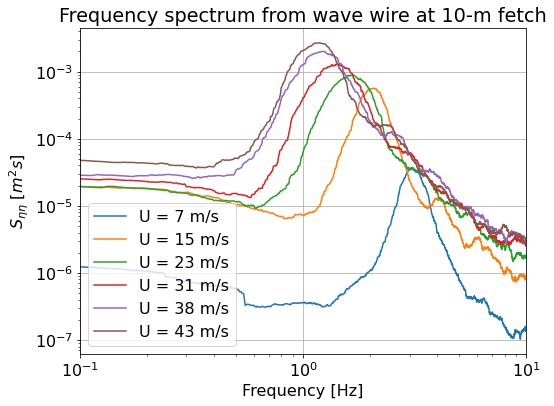

In [15]:
plt.figure(figsize=(8, 6))
for n in range(1, 13, 2):
    plt.loglog(freq, smooth(F[n,:], 256), label='U = %i m/s' % U[n])
plt.legend(loc='bottom left')
plt.grid()
plt.xlim(1e-1, 1e1)
plt.xlabel('Frequency [Hz]')
plt.ylabel(r'$S_{\eta\eta}\ [m^2 s]$')
plt.title('Frequency spectrum from wave wire at 10-m fetch')

## Set up and run simulations

In [56]:
fmin = 0.1 # Hz
fmax = 10 # Hz
num_frequencies = 50

xmin = 0 # m
xmax = 10 # m
num_grid_points = 101

water_depth = 0.8

f = frequency_logspace(fmin, fmax, num_frequencies)
x = np.linspace(xmin, xmax, num_grid_points, endpoint=True)
f, x = np.meshgrid(f, x)
depth = water_depth * np.ones(x.shape)
k = wavenumber(f, depth)
cp = phase_speed(f, k)
cg = group_speed(f, k, depth)
dk = 2 * np.pi * f / cg

In [57]:
wspd = U[range(1, 13, 2)]

In [58]:
duration = 600
output_interval = 10

In [59]:
def simulate(wspd, Fk_init, 
             sheltering_coefficient=0.11, 
             snl_coefficient=1, 
             mss_coefficient=120, 
             dissipation_coefficient=42,
             dissipation_power=2.4):
    sig_wave_height = np.zeros((wspd.size))
    mean_wave_period = np.zeros((wspd.size))
    peak_wave_period = np.zeros((wspd.size))
    mean_square_slope = np.zeros((wspd.size))
    stress = np.zeros((wspd.size))
    spectrum = np.zeros((wspd.size, num_frequencies))
    for n, w in enumerate(wspd):
        print('Integrating for wind speed ', w)
        time, swh, mwp, dwp, mss, tau, Fk = integrate(Fk_init, f, k, cp, cg, x, w, duration, output_interval, \
                                                      snl_coefficient=snl_coefficient, \
                                                      mss_coefficient=mss_coefficient, \
                                                      dissipation_coefficient=dissipation_coefficient, \
                                                      dissipation_power=dissipation_power, \
                                                      sheltering_coefficient=sheltering_coefficient)
        sig_wave_height[n] = swh[-1,-1]
        mean_wave_period[n] = mwp[-1,-1]
        peak_wave_period[n] = dwp[-1,-1]
        mean_square_slope[n] = mss[-1,-1]
        stress[n] = tau[-1,-1]
        spectrum[n,:] = Fk[-1,:]
    return sig_wave_height, mean_wave_period, peak_wave_period, mean_square_slope, stress, spectrum

In [60]:
Fk_init = wind_wave_balance(source_input(0.8, f, k, cp), f, k)

In [61]:
run1 = simulate(wspd, Fk_init, dissipation_power=8, snl_coefficient=2)

Integrating for wind speed  7.887218914267197
integrate: time step 59/60
Integrating for wind speed  15.71692477270623
integrate: time step 59/60
Integrating for wind speed  23.488137775307955
integrate: time step 59/60
Integrating for wind speed  31.035572759446236
integrate: time step 59/60
Integrating for wind speed  38.02098254151421
integrate: time step 59/60
Integrating for wind speed  43.68144806950673
integrate: time step 59/60


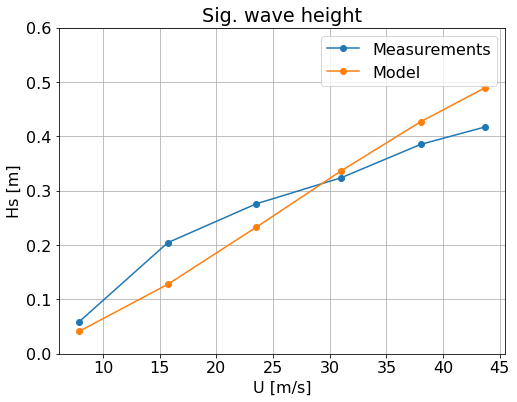

In [67]:
plt.figure(figsize=(8, 6))
plt.plot(wspd, Hs[[1, 3, 5, 7, 9, 11]], marker='o', label='Measurements')
plt.plot(wspd, run1[0], marker='o', label='Model')
plt.legend()
plt.xlabel('U [m/s]')
plt.ylabel('Hs [m]')
plt.title('Sig. wave height')
plt.ylim(0, 0.6)
plt.grid()

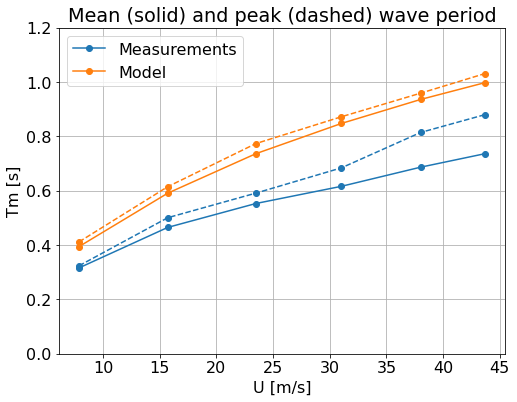

In [70]:
plt.figure(figsize=(8, 6))
plt.plot(wspd, Tm[[1, 3, 5, 7, 9, 11]], color='tab:blue', marker='o', label='Measurements')
plt.plot(wspd, Tp[[1, 3, 5, 7, 9, 11]], color='tab:blue', marker='o', linestyle='--')
plt.plot(wspd, run1[1], marker='o', color='tab:orange', label='Model')
plt.plot(wspd, run1[2], marker='o', color='tab:orange', linestyle='--')
plt.legend()
plt.xlabel('U [m/s]')
plt.ylabel('Tm [s]')
plt.title('Mean (solid) and peak (dashed) wave period')
plt.ylim(0, 1.2)
plt.grid()

Text(0.5, 1.0, 'Frequency spectra from wave wire (solid) and model (dashed)')

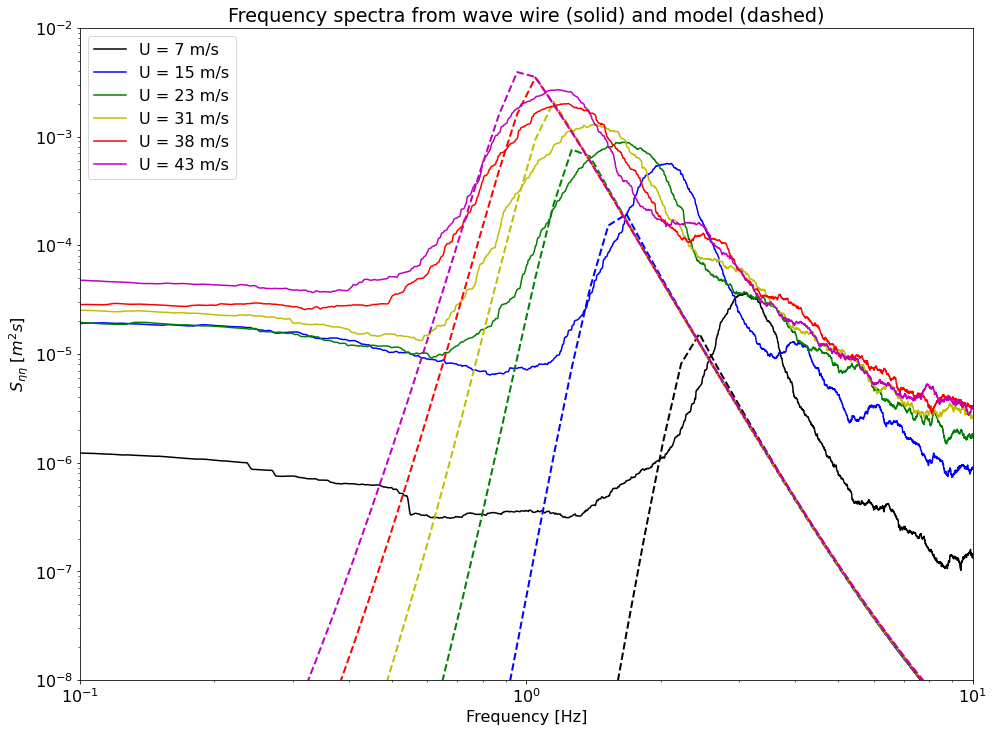

In [81]:
colors = ['k', 'b', 'g', 'y', 'r', 'm']

plt.figure(figsize=(16, 12))
for i, n in enumerate(range(1, 13, 2)):
    plt.loglog(freq, smooth(F[n,:], 256), label='U = %i m/s' % U[n], color=colors[i])
    plt.loglog(f[0,:], run1[-1][i,:] * 2 * np.pi / cg[0,:], color=colors[i], linestyle='--', lw=2)
plt.xlim(1e-1, 1e1)
plt.ylim(1e-8, 1e-2)
plt.legend(loc='upper left')
plt.xlabel('Frequency [Hz]')
plt.ylabel(r'$S_{\eta\eta}\ [m^2 s]$')
plt.title('Frequency spectra from wave wire (solid) and model (dashed)')